In [23]:
import sys
sys.path.append('..')
from swdf.utils import *
convert_uuids_to_indices()
import sklearn
from tsai.basics import *
my_setup(sklearn)
from matplotlib import dates as mdates
import wandb
from fastai.callback.wandb import WandbCallback
from fastai.callback.progress import ShowGraphCallback

os              : Linux-6.8.0-39-generic-x86_64-with-glibc2.31
python          : 3.10.12
tsai            : 0.3.10
fastai          : 2.7.15
fastcore        : 1.5.49
sklearn         : 1.5.1
torch           : 2.2.2+cu121
device          : 1 gpu (['NVIDIA GeForce RTX 3070 Ti Laptop GPU'])
cpu cores       : 14
threads per cpu : 1
RAM             : 15.28 GB
GPU memory      : [8.0] GB


In [24]:
# This is only needed for the MIT supercloud, to fix fastai's LRFinder error 
if torch.cuda.is_available() and torch.cuda.device_count() == 0:
    from fastai.callback.schedule import LRFinder

    @patch_to(LRFinder)
    def after_fit(self):
        self.learn.opt.zero_grad() # Needed before detaching the optimizer for future fits
        tmp_f = self.path/self.model_dir/self.tmp_p/'_tmp.pth'
        if tmp_f.exists():
            self.learn.load(f'{self.tmp_p}/_tmp', with_opt=True, device='cpu')
            self.tmp_d.cleanup()

In [25]:
config_base = yaml2dict('./config/base.yaml', attrdict=True)
config_dstap = yaml2dict('./config/dstap.yaml', attrdict=True).train

# Merge the two configs (the second one overrides the first one for any keys that are present in both)
config = AttrDict({**config_base, **config_dstap})
# Add the architecture config
if config.arch_name.lower() == 'patchtst':
    config.arch = yaml2dict('./config/patchtst.yaml', attrdict=True)
else:
    config.arch = AttrDict()

In [26]:
run = wandb.init(project=config.wandb.project, 
                 config=config,
                 group=config.wandb.group,
                 mode=config.wandb.mode, 
                 anonymous='never') if config.wandb.enabled else None
config = dict2attrdict(run.config) if config.wandb.enabled else config

In [27]:
config

```json
{ 'add_time_channels': False,
  'arch': {'d_model': 512, 'n_heads': 32},
  'arch_config_file': 'config/patchtst.yaml',
  'arch_name': 'PatchTST',
  'bs': 32,
  'deltaHL': 2.0,
  'horizon': 48,
  'init_weights': False,
  'is_optuna_study': False,
  'lookback': 144,
  'lr_max': 1e-06,
  'n_epoch': 200,
  'partial_n': 0.001,
  'seed': 42,
  'test_end_datetime': '2018-12-31 12:00:00',
  'test_start_datetime': '2012-10-01 12:00:00',
  'valid_start_datetime': '2018-01-01 12:00:00',
  'wandb': { 'enabled': False,
             'group': None,
             'log_learner': True,
             'mode': 'offline',
             'project': 'swdf'}}
```

In [28]:
df_ap = load_object("./preprocessed_data/dataframes/ap.pkl")
df_dst = load_object("./preprocessed_data/dataframes/dst.pkl")

In [29]:
df_dst.set_index('Datetime', inplace=True)
df_dst = df_dst.resample('3H').mean().round(1)
df_dst = df_dst.reset_index()
df_dst

,Datetime,DST
0,1957-01-01 00:00:00,12.000000
1,1957-01-01 03:00:00,9.300000
2,1957-01-01 06:00:00,5.000000
3,1957-01-01 09:00:00,-5.000000
4,1957-01-01 12:00:00,0.000000
...,...,...
197518,2024-08-06 18:00:00,-14.300000
197519,2024-08-06 21:00:00,-18.700001
197520,2024-08-07 00:00:00,-17.299999
197521,2024-08-07 03:00:00,-16.000000


In [30]:
columns = ['Datetime', 'DOY', 'DST', 'AP']

df_raw = df_ap.merge(df_dst, on='Datetime', how='right')
df_raw['DOY'] = df_raw['Datetime'].dt.dayofyear

df_raw = df_raw[columns]

df_raw

,Datetime,DOY,DST,AP
0,1957-01-01 00:00:00,1,12.000000,2
1,1957-01-01 03:00:00,1,9.300000,3
2,1957-01-01 06:00:00,1,5.000000,3
3,1957-01-01 09:00:00,1,-5.000000,22
4,1957-01-01 12:00:00,1,0.000000,15
...,...,...,...,...
197518,2024-08-06 18:00:00,219,-14.300000,5
197519,2024-08-06 21:00:00,219,-18.700001,6
197520,2024-08-07 00:00:00,220,-17.299999,4
197521,2024-08-07 03:00:00,220,-16.000000,6


In [31]:
print(df_raw.isna().sum())
df_raw.dropna(inplace=True) # As are the values desfased between both indices

print(df_raw.isna().sum())

Datetime    0
DOY         0
DST         0
AP          0
dtype: int64
Datetime    0
DOY         0
DST         0
AP          0
dtype: int64


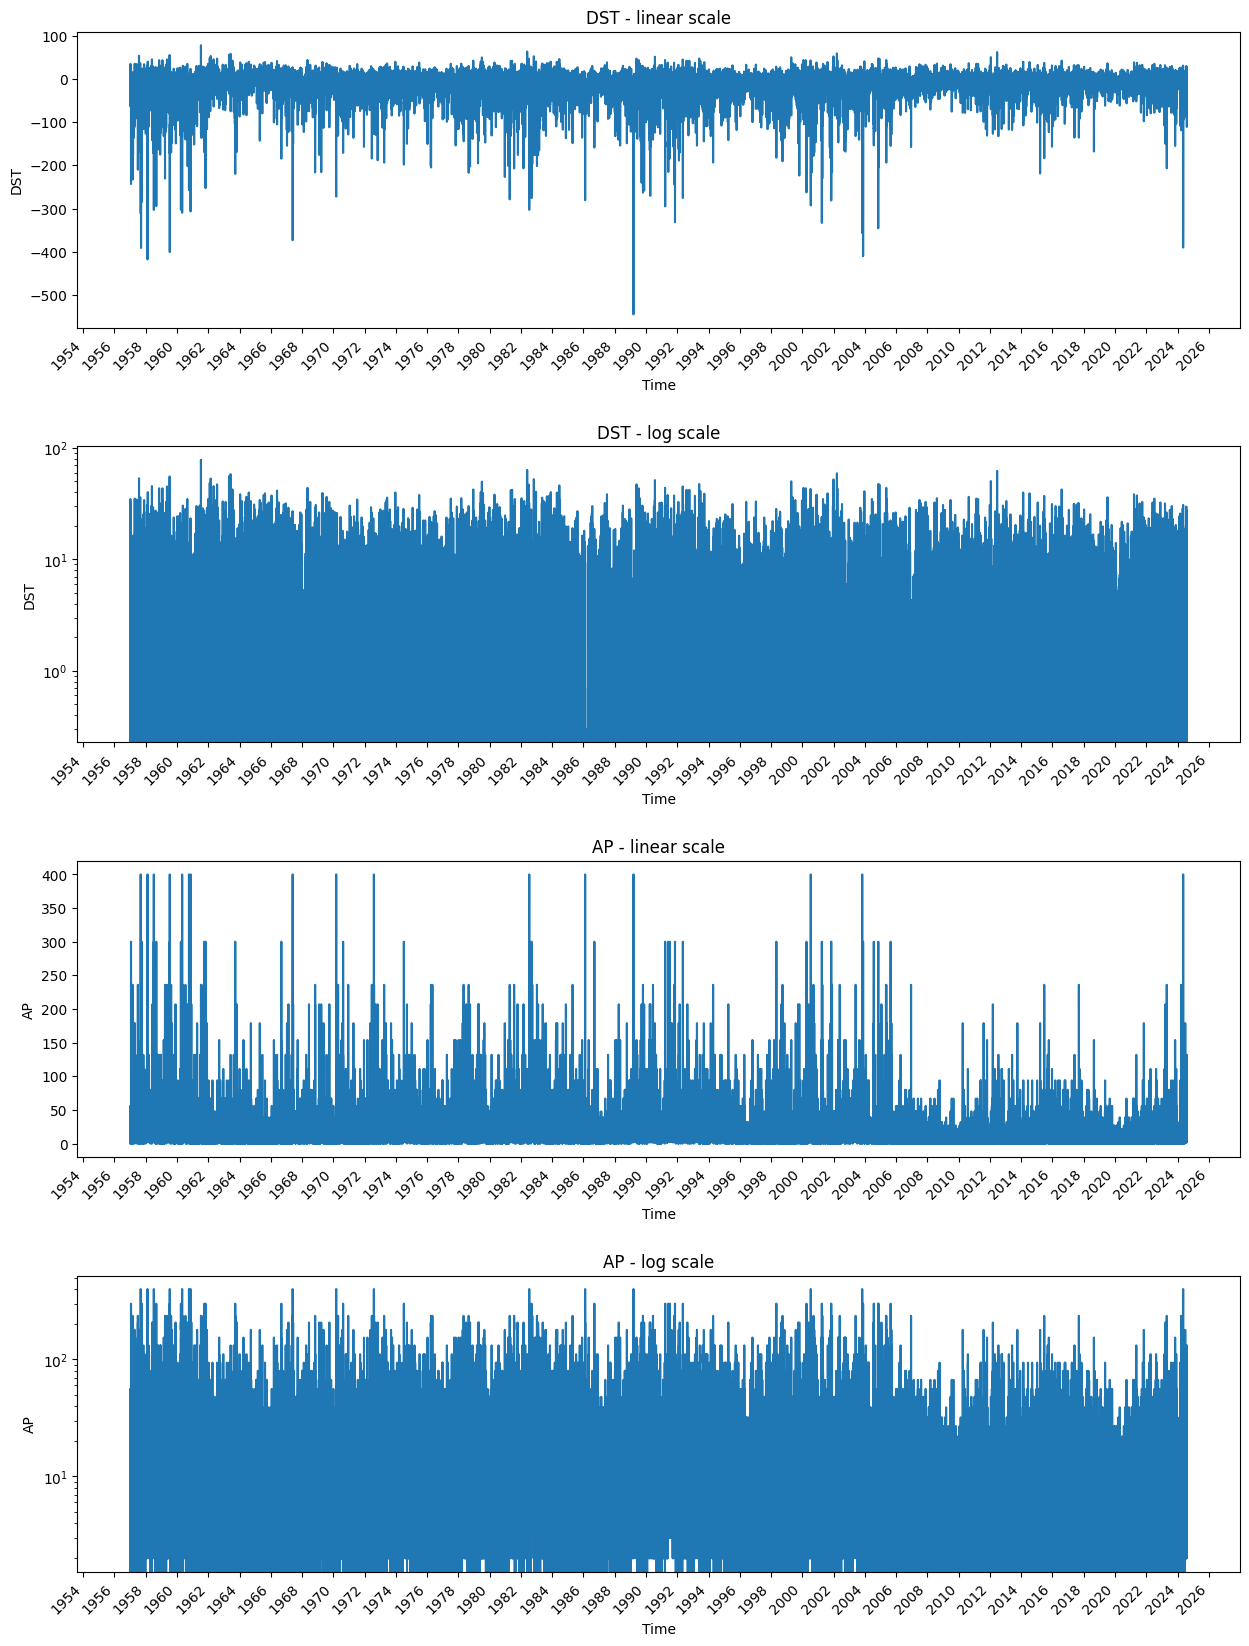

In [32]:
columns = ['DST', 'AP']
scales = ['linear', 'log']

fig, ax = plt.subplots(4, 1, figsize=(15, 20))
plt.subplots_adjust(hspace=0.4)

i = 0

for column in columns:
    for scale in scales:

        ax[i].set_yscale(scale)
        
        ax[i].plot(df_raw.Datetime, df_raw[column])
        
        ax[i].set_title(f'{column} - {scale} scale')
        ax[i].set_xlabel('Time')
        ax[i].set_ylabel(column)
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) # format x-axis ticks
        
        ax[i].xaxis.set_major_locator(mdates.YearLocator(2))
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        plt.setp(ax[i].get_xticklabels(), rotation=45, ha="right")
        
        i += 1
      
plt.show()

In [33]:
preproc_pipe = sklearn.pipeline.Pipeline([
    ('shrinker', TSShrinkDataFrame()), # shrink dataframe memory usage and set the right dtypes
], verbose=True)

df = preproc_pipe.fit_transform(df_raw)
df

Initial memory usage: 3.39 MB   
Final memory usage  : 3.01 MB    (-11.1%)
[Pipeline] .......... (step 1 of 1) Processing shrinker, total=   0.0s


,Datetime,DOY,DST,AP
0,1957-01-01 00:00:00,1,12.000000,2
1,1957-01-01 03:00:00,1,9.300000,3
2,1957-01-01 06:00:00,1,5.000000,3
3,1957-01-01 09:00:00,1,-5.000000,22
4,1957-01-01 12:00:00,1,0.000000,15
...,...,...,...,...
197518,2024-08-06 18:00:00,219,-14.300000,5
197519,2024-08-06 21:00:00,219,-18.700001,6
197520,2024-08-07 00:00:00,220,-17.299999,4
197521,2024-08-07 03:00:00,220,-16.000000,6


In [34]:
save_object(df, "./preprocessed_data/dataframes/dstap.pkl")

preprocessed_data/dataframes directory already exists.
DataFrame saved as preprocessed_data/dataframes/dstap.pkl


# Train

In [35]:
# In the paper by Licata et al. (2020) (https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1029/2020SW002496),
# authors use a period from October 2012 through the end of 2018 for the benchmarking.
# Therefore, we will set the test set as the same period for our analysis, 
# using the column Date as the timestamp, from October 2012 to the end of 2018. 
# Everything before the test set will be used for training, and everything after the test set
# will be used for validation
test_start_datetime = config.test_start_datetime
test_end_datetime = config.test_end_datetime
valid_start_datetime = config.valid_start_datetime

In [36]:
data_columns = ['AP', 'DST']
data_columns_time = ['DOY']
data_columns_fcst = data_columns + data_columns_time if config.add_time_channels else data_columns
data_columns

['AP', 'DST']

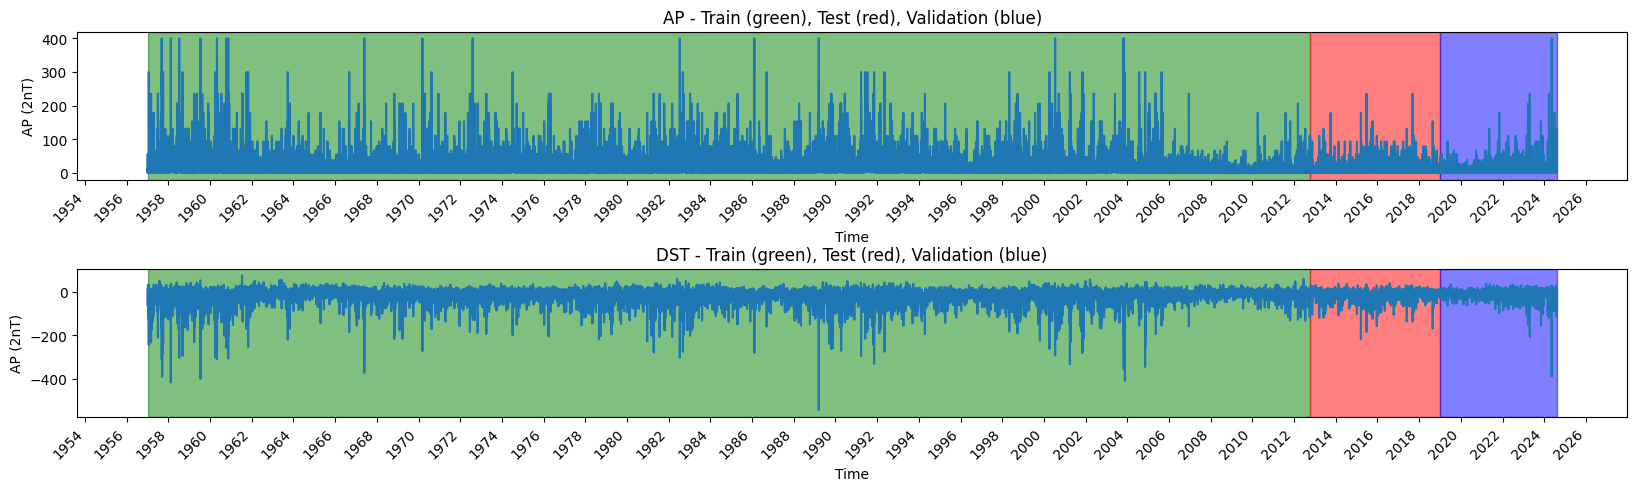

In [37]:
# hide

fig, ax = plt.subplots(2, 1, figsize=(20, 5))
plt.subplots_adjust(hspace=0.6)

for i, value in enumerate(data_columns): 
    ax[i].plot(df.Datetime, df[value])
    ax[i].axvspan(df.Datetime.min(), test_start_datetime, alpha=0.5, color='green')
    ax[i].axvspan(test_start_datetime, test_end_datetime, alpha=0.5, color='red')
    ax[i].axvspan(test_end_datetime, df.Datetime.max(), alpha=0.5, color='blue')
    ax[i].set_title(f'{value} - Train (green), Test (red), Validation (blue)')
    ax[i].set_xlabel('Time')
    ax[i].set_ylabel('AP (2nT)')
    ax[i].xaxis.set_major_locator(mdates.YearLocator(2))
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    ax[i].xaxis.set_major_locator(mdates.YearLocator(2))
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.setp(ax[i].get_xticklabels(), rotation=45, ha="right")
plt.show()

In [38]:
splits_ = get_forecasting_splits(df[df.Datetime < valid_start_datetime], 
                             fcst_history=config.lookback, 
                             fcst_horizon=config.horizon, 
                             use_index=False, 
                             test_cutoff_datetime=test_start_datetime, 
                             show_plot=False, 
                             datetime_col='Datetime')
foo = df[df.Datetime >= valid_start_datetime]
bar = get_forecasting_splits(foo, config.lookback, config.horizon, valid_size=0.0, 
                             test_size=0.0, show_plot=False)
val_idxs = L(foo.index[bar[0]].tolist())

splits = (splits_[0], val_idxs, splits_[1])
splits

((#162710) [0,1,2,3,4,5,6,7,8,9...],
 (#19088) [178244,178245,178246,178247,178248,178249,178250,178251,178252,178253...],
 (#15296) [162757,162758,162759,162760,162761,162762,162763,162764,162765,162766...])

In [39]:
# Now that we have defined the splits for this particular experiment, we'll scale
# the data
train_split = splits[0]
exp_pipe = sklearn.pipeline.Pipeline([
    ('scaler', TSStandardScaler(columns=data_columns)),
], verbose=True)
save_object(exp_pipe, 'tmp/exp_pipe.pkl')
exp_pipe = load_object('tmp/exp_pipe.pkl')
# TODO: I don't know why but if I don't copy the dataframe df it gets modified
df_scaled = exp_pipe.fit_transform(df.copy(), scaler__idxs = train_split)
#df_scaled.set_index(datetime_col, inplace=True)
df_scaled.head()

tmp directory already exists.
Pipeline saved as tmp/exp_pipe.pkl
[Pipeline] ............ (step 1 of 1) Processing scaler, total=   0.0s


,Datetime,DOY,DST,AP
0,1957-01-01 00:00:00,1,1.156901,-0.584428
1,1957-01-01 03:00:00,1,1.043766,-0.534888
2,1957-01-01 06:00:00,1,0.863589,-0.534888
3,1957-01-01 09:00:00,1,0.444572,0.406378
4,1957-01-01 12:00:00,1,0.654080,0.059596


In [40]:
# We'll approach the time series forecasting task as a supervised learning problem. 
# Remember that tsai requires that both inputs and outputs have the following shape:
# (samples, features, steps)

# To get those inputs and outputs we're going to use a function called 
# `prepare_forecasting_data`` that applies a sliding window along the dataframe
X, y = prepare_forecasting_data(df, fcst_history=config.lookback, 
                                fcst_horizon=config.horizon,
                                x_vars=data_columns, 
                                y_vars=data_columns_fcst)

X.shape, y.shape

((197332, 2, 144), (197332, 2, 48))

In [41]:
thresholds = {
    "AP": [
        (-np.inf, 10),  # Low
        (10, 50),    # Moderate
        (50, np.inf)   # Active
    ],
    "DST": [
        (-30, np.inf),    # G0
        (-50, -30),     # G1
        (-90, -50),     # G2
        (-130, -90),    # G3
        (-350, -130),   # G4
        (-np.inf, -350)    # G5
    ]
}

activity_levels = {
    'AP': ["Low", "Moderate", "Active"],
    'DST': ["G0", "G1", "G2", "G3", "G4", "G5"]
}

In [42]:
df_cat = get_classified_columns(df, thresholds, activity_levels)

def get_weights(column:pd.Series):
    distribution = column.value_counts(normalize=True).to_dict()
    inverted_weights = {k: 1/v for k, v in distribution.items()}
    total_weight = sum(inverted_weights.values())
    weights = [v/total_weight for v in inverted_weights.values()]
    return weights

weights = {column: get_weights(df_cat[df.Datetime < test_start_datetime][f'{column}_Cat']) for column in data_columns}
weights

{'AP': [0.05027553210414406, 0.08743208708643083, 0.862292380809425],
 'DST': [8.803351903177007e-05,
  0.0006020729557296344,
  0.0014018781299297467,
  0.007761028027872513,
  0.01549121753377997,
  0.9746557698336564]}

#params: 16621670


epoch,train_loss,valid_loss,time
0,3.315006,6.274571,00:24
1,3.095133,6.274082,00:24
2,6.774791,6.273582,00:24
3,5.695602,6.273049,00:24
4,4.805280,6.272465,00:24
5,4.465704,6.271798,00:24
6,4.014048,6.271046,00:24
7,3.683657,6.270180,00:24
8,4.459342,6.269155,00:24
9,4.200138,6.267953,00:24


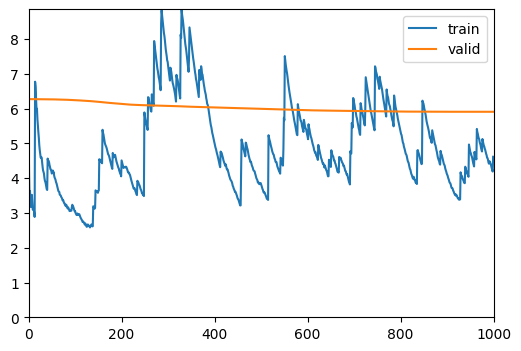

In [43]:
from swdf.losses import *

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
loss = wHubberLoss(thresholds, weights, delta=config.deltaHL).to(device)
a,b=torch.Tensor(list(np.random.rand(32,2,36)))*200, torch.Tensor(np.random.rand(32,2,36))*200

wandb_callback = WandbCallback(log_preds=False)
cbs = L(wandb_callback) if config.wandb.enabled else L()
learn = TSForecaster(X, y, splits=splits, batch_size=config.bs, 
                     loss_func=loss,
                     pipelines=[preproc_pipe, exp_pipe],
                     arch='TSiT', arch_config=config.arch,
                     init=config.init_weights,
                     cbs= cbs + ShowGraphCallback(),
                     partial_n=config.partial_n)

lr_max = learn.lr_find().valley if config.lr_max is None else config.lr_max

print(f"#params: {sum(p.numel() for p in learn.model.parameters())}")
learn.fit_one_cycle(n_epoch=config.n_epoch, lr_max=lr_max)

In [44]:
# Print the validation loss and save it in case other notebooks (optuna) wants to
# use it for hyperparameter optimization
valid_loss = learn.validate()[0]

print(valid_loss)
%store valid_loss

5.910577774047852
Stored 'valid_loss' (float)


In [45]:
# Save everything
learn.dls.loaders += [learn.dls.valid.new_dl(X[splits[2]], y[splits[2]])] # Add test datalaoder

# Remove the wandb callback to avoid errors when downloading the learner
if config.wandb.enabled:
    learn.remove_cb(wandb_callback)

In [46]:
best_valid_loss = np.inf
%store -r best_valid_loss

save_all_or_best = (config.is_optuna_study and valid_loss < best_valid_loss) or not config.is_optuna_study

if save_all_or_best:
    best_valid_loss = valid_loss
    %store best_valid_loss                                             

    # Save locally and in wandb if online and enabled
    learn.save_all(path='tmp', verbose=True, model_fname='model_dstap', learner_fname="learner_dstap") 
    if run is not None and config.wandb_mode and config.wandb_log_learner:
        # Save the learner (all tmp/dls, tmp/model.pth, and tmp/learner.pkl). 
        run.log_artifact('tmp', type='learner', name='solfsmy')
    
    # Save the best model
    model = {}
    model['models'] = [learn.model]
    model['lookback'] = config.lookback
    model['horizon'] = config.horizon
    model['data_columns'] = data_columns
    model['thresholds'] = thresholds

    torch.save(model, 'models/best_model.pth')

Stored 'best_valid_loss' (float)
Learner saved:
path          = 'tmp'
dls_fname     = '['dls_0.pth', 'dls_1.pth', 'dls_2.pth', 'dls_3.pth']'
model_fname   = 'model_dstap.pth'
learner_fname = 'learner_dstap.pkl'


In [47]:
# Log the test loss to wandb
test_loss = learn.validate(ds_idx=2)[0]
print(test_loss)
if run is not None:
    run.log(dict(test_loss=test_loss))

0.9121678471565247


In [48]:
if run is not None:
    run.finish()